Group assignment: Second-level analysis
===

## Goals
- Perform second-level analysis on a real-world dataset
- Present the results in the form of a data blitz (short presentation giving an overview on the research).
## Task
- Perform a (partial) replication of the associated paper’s statistical analysis
- Present results (note that you may not be able to perform every analysis included in the original study due to missing data or complexity etc.).
- You get extra points by including further analyses you can think of (however, you should discuss this with us before implementing it, so we can make sure that everything is correct).  

## Data
- Already preprocessed and modelled on a first level with contrast maps for each subject.


## Steps
### 1. Definition of research project:
- Basic replication using the data available to you, including
    - Whole-brain univariate analysis
    - ROI analysis (alternatively: connectivity analysis)
    - Additional analyses (optional, discuss first with us)
### 2. Project presentation (13.12.2022):
- Briefly present study/analysis plan
- 5 minutes; 5 slides; one person presents
- Suggested slide outline: 1 slide study/background, 1 slide study design, 2 slides analysis plan, 1 slide outlook/implications
- ad. analysis plan:
    - Present the analysis described in the paper; state which parts you want to take for your own analysis and which not (and why)
    - Please upload the slides on Moodle before the practical (13.12.22); this will act as an internal ‘pre-registration’ of the research project
### 3. Potential revision of research project:
- After the project presentation, incorporate feedback and perhaps upload a revised version of the slides
### 4. Work on analysis:
- The contrast maps will be provided as soon as possible (most likely before the 13th December; if you want to start before that, you can setup your analysis using dummy data (e.g. using Nilearn’s fetch_localizer_contrasts() function )
### 5. Uploaded recorded status quo presentation (17.01.2023):
- Please record (e.g., using Zoom) a brief presentation of the status quo of your analysis (precise instructions will follow). We will provide feedback that you can incorporate into your analysis and final slides.
### 6. Prepare data blitz presentation
- Precise instructions will follow
- Hand in final slides: 24.01.2023 (via Moodle)
### 7. Data blitz (25.01.2023):
- Hold presentation at data blitz session with SCAN-Unit members.
- precise instructions will follow
- We will determine the “winner” presentation based on audience vote (does not count for the grade, but just as a motivation).


# 0. Setup

## Imports

In [1]:
import jupyter_black

jupyter_black.load()

In [5]:
from nipype import config

cfg = dict(
    logging=dict(workflow_level="INFO"),
    execution={
        "stop_on_first_crash": "True",
        "hash_method": "content",
        "remove_unnecessary_outputs": "True",
    },
)
config.update_config(cfg)

import os
from os.path import join as opj
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, image
from pprint import pprint


# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


In [6]:
os.environ["FSLOUTPUTTYPE"] = "NIFTI"

## Download data

In [7]:
n_subjects = 20

con_left_right = datasets.fetch_localizer_contrasts(
    ["right vs left button press"], n_subjects
)


Dataset created in /root/nilearn_data/brainomics_localizer



 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)
 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)
/usr/local/lib/python3.9/site-packages/nilearn/datasets/func.py:764: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [8]:
print(f"data is stored in: {datasets.get_data_dirs()[0]}")

data is stored in: /root/nilearn_data


In [9]:
from glob import glob

cmaps = sorted(
    glob(
        f"{datasets.get_data_dirs()[0]}/brainomics_localizer/brainomics_data/**/*.nii.gz",
        recursive=True,
    )
)

pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

['/root/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S02/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S03/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S04/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S05/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S06/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S07/cmaps_RightAuditory&VisualClickVsLeftAuditory&VisualClick.nii.gz',
 '/root/nilearn_data/brainomics_localizer/brainomics_data/S08/cmaps_RightAuditory&VisualClickVsLe

In [10]:
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]
pprint(subject_list)

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-10',
 'sub-11',
 'sub-12',
 'sub-13',
 'sub-14',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18',
 'sub-19',
 'sub-20']


# Second-level analysis

## Basic model

In [11]:
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix

,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1
sub-06,1
sub-07,1
sub-08,1
sub-09,1
sub-10,1


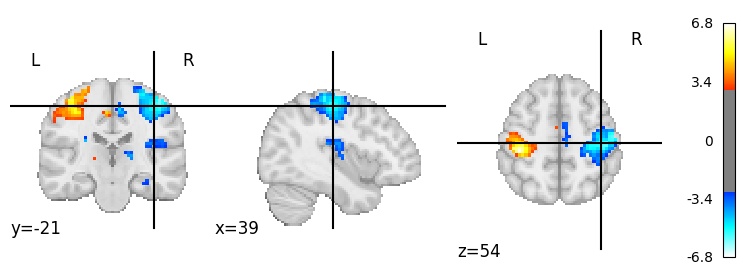

In [40]:
from nilearn.glm.second_level import SecondLevelModel

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

right_left_avg = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="z_score"
)

plotting.plot_stat_map(right_left_avg, threshold=3)

## Hypothetical group comparison


In [43]:
design_matrix_groups = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

# start by initializing the group dummy columns
design_matrix_groups["group_young"] = 0
design_matrix_groups["group_old"] = 0

design_matrix_groups

,intercept,group_young,group_old
sub-01,1,0,0
sub-02,1,0,0
sub-03,1,0,0
sub-04,1,0,0
sub-05,1,0,0
sub-06,1,0,0
sub-07,1,0,0
sub-08,1,0,0
sub-09,1,0,0
sub-10,1,0,0


In [41]:
design_matrix_groups.loc[subject_list[:10], "group_young"] = 1
design_matrix_groups.loc[subject_list[10:], "group_old"] = 1

design_matrix_groups

,intercept,group_young,group_old
sub-01,1,1,0
sub-02,1,1,0
sub-03,1,1,0
sub-04,1,1,0
sub-05,1,1,0
sub-06,1,1,0
sub-07,1,1,0
sub-08,1,1,0
sub-09,1,1,0
sub-10,1,1,0


In [20]:
second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix_groups)

## Define contrasts

In [22]:
contrast_matrix = np.eye(design_matrix_groups.shape[1])
contrast_matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
contrasts = dict(
    [
        (column, contrast_matrix[i])
        for i, column in enumerate(design_matrix_groups.columns)
    ]
)
print(contrasts)

{'intercept': array([1., 0., 0.]), 'group_young': array([0., 1., 0.]), 'group_old': array([0., 0., 1.])}


In [24]:
contrasts["group_old-young"] = contrasts["group_old"] - contrasts["group_young"]
contrasts["group_young-old"] = -contrasts["group_old"] + contrasts["group_young"]
pprint(contrasts)

{'group_old': array([0., 0., 1.]),
 'group_old-young': array([ 0., -1.,  1.]),
 'group_young': array([0., 1., 0.]),
 'group_young-old': array([ 0.,  1., -1.]),
 'intercept': array([1., 0., 0.])}


In [25]:
cmaps_second = {con: None for con in contrasts}

for con in contrasts:
    print(f"\nRunning {con}...")
    print(f" - Calculating contrast...")
    res = second_level.compute_contrast(contrasts[con], output_type="z_score")
    cmaps_second[con] = res
    print("done.")


Running intercept...
 - Calculating contrast...
done.

Running group_young...
 - Calculating contrast...
done.

Running group_old...
 - Calculating contrast...
done.

Running group_old-young...
 - Calculating contrast...
done.

Running group_young-old...
 - Calculating contrast...
done.


## Correcting multiple comparisons

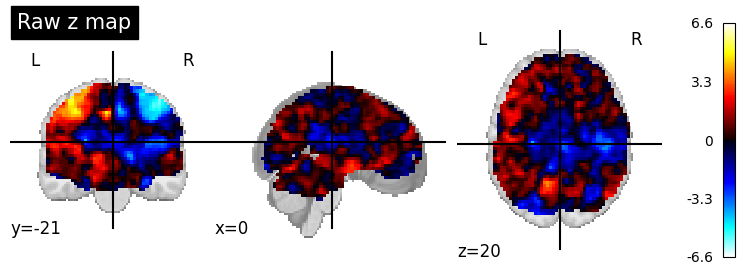

In [26]:
disp = plotting.plot_stat_map(cmaps_second["intercept"], title="Raw z map")

In [27]:
from nilearn.glm import threshold_stats_img

thresholded_map, threshold = threshold_stats_img(
    cmaps_second["intercept"], alpha=0.05, height_control="fdr", cluster_threshold=10
)

print(f"The FDR=.05 threshold is {round(threshold, 3)}")

The FDR=.05 threshold is 3.197


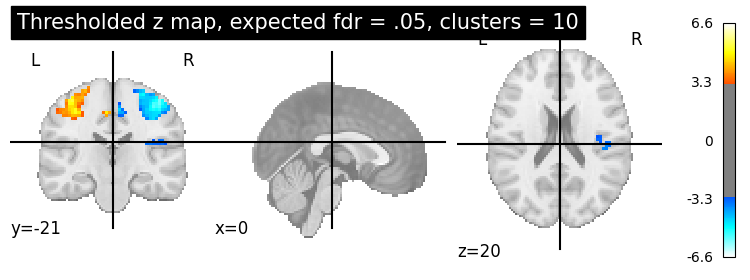

In [28]:
plotting.plot_stat_map(
    thresholded_map,
    cut_coords=disp.cut_coords,
    title="Thresholded z map, expected fdr = .05, clusters = 10",
    threshold=threshold,
)

# 2. Store objects

In [39]:
import pickle

pickle.dump(second_level, open("second_level.pkl", "wb"))
!ls ./

'Group assignment.ipynb'        __pycache__   output
'Individual assignment.ipynb'   data	      second_level.pkl


In [38]:
secondlvl_pkl = pickle.load(open("second_level.pkl", "rb"))

secondlvl_pkl.design_matrix_

,intercept,group_young,group_old
sub-01,1,1,0
sub-02,1,1,0
sub-03,1,1,0
sub-04,1,1,0
sub-05,1,1,0
sub-06,1,1,0
sub-07,1,1,0
sub-08,1,1,0
sub-09,1,1,0
sub-10,1,1,0


As we have pickled the already fitted object, we can go ahead and evaluate some contrasts (without fitting the model again):

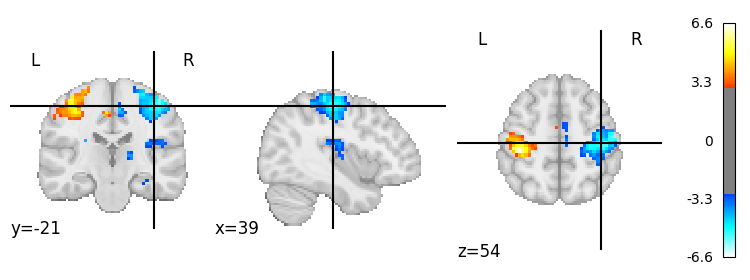

In [37]:
right_left_pkl = secondlvl_pkl.compute_contrast(
    second_level_contrast="intercept", output_type="z_score"
)

plotting.plot_stat_map(right_left_pkl, threshold=3)